<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-3)" data-toc-modified-id="Общее-впечатление-(ревью-3)-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 3)</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-4)" data-toc-modified-id="Общее-впечатление-(ревью-4)-0.4"><span class="toc-item-num">0.4&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 4)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Библиотеки**

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import catboost as cb

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import warnings

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

## Подготовка

**Открываем датасет**

In [2]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0]) 

**Проверим ненарушена ли хронология**

In [3]:
display(data.index.is_monotonic)

True

**Выполним ресемплирование данных по одному часу**

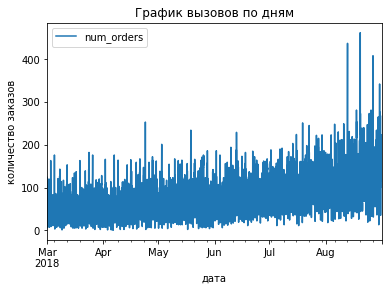

In [4]:
data = data.resample('1H').sum()
data.plot(ylabel='количество заказов', xlabel='дата')
plt.title('График вызовов по дням');


## Анализ

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


4416 строк. Пропусков нет. Данные за 2018 год, начинаются с 1 марта и заканчиваются 31 августа

**Первые строки датасета наглядно**

In [6]:
display(data.head(10))

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


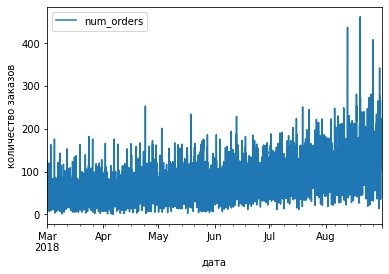

In [7]:
data.plot(ylabel='количество заказов', xlabel='дата');

**Данные сливаются в шум, посмотрим на скользящую среднюю**

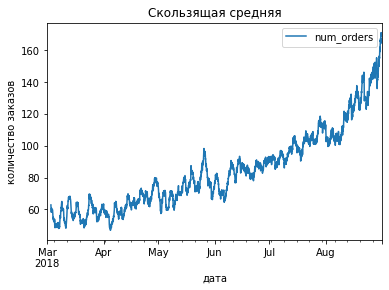

In [8]:
data.rolling(50).mean().plot(title='Скользящая средняя', ylabel='количество заказов', xlabel='дата');

Благодаря скользящей средней мы  смогли увидеть восхдящий тренд

**Рассмотрим тернды, сезонность, остаток декомпозиции по заказам такси**

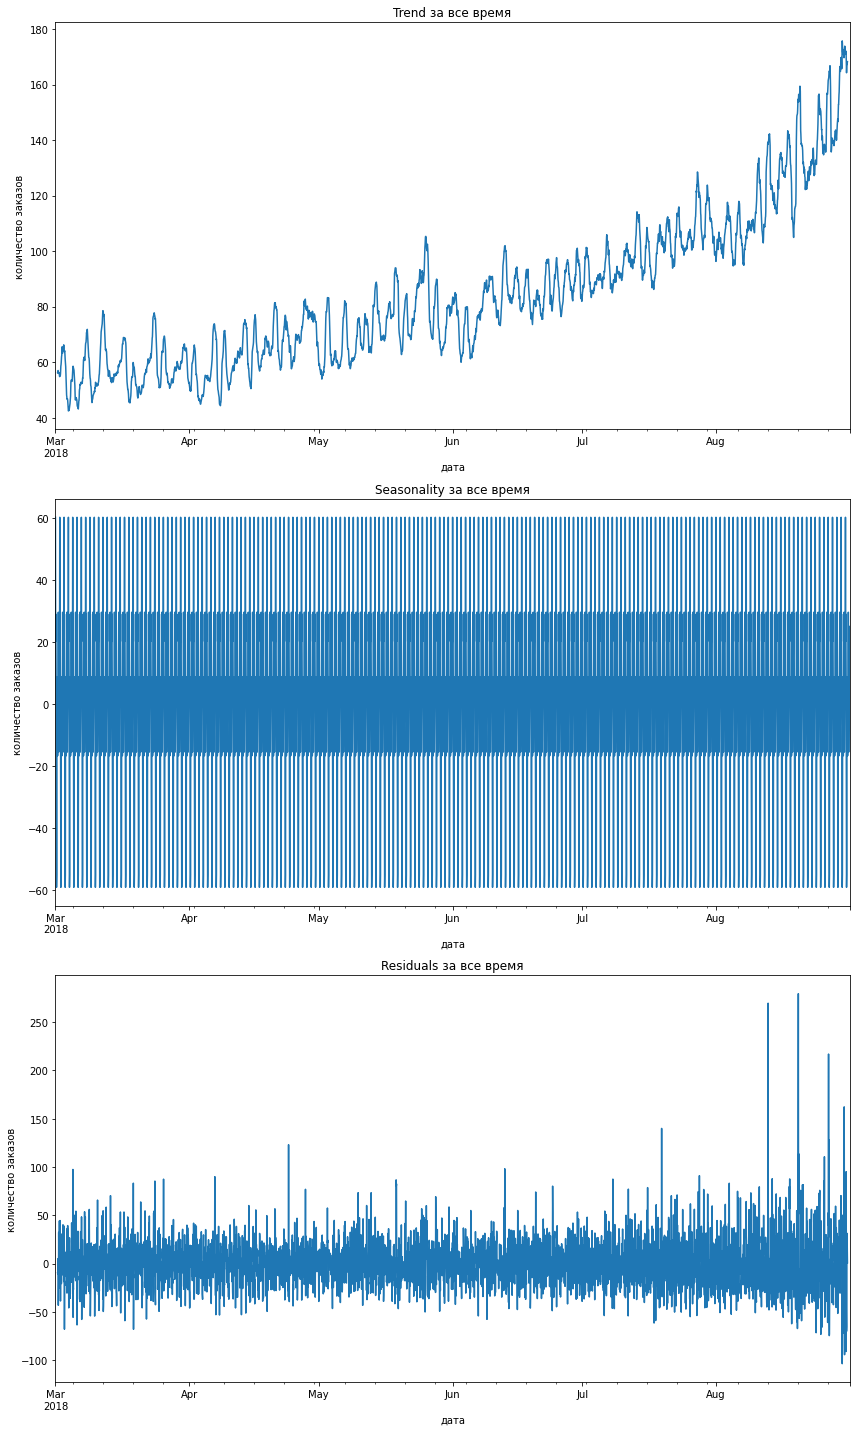

In [9]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ylabel='количество заказов', xlabel='дата', ax=plt.gca())
plt.title('Trend за все время')

plt.subplot(312)
decomposed.seasonal.plot(ylabel='количество заказов', xlabel='дата', ax=plt.gca())
plt.title('Seasonality за все время')

plt.subplot(313)
decomposed.resid.plot(ylabel='количество заказов', xlabel='дата', ax=plt.gca())
plt.title('Residuals за все время')
plt.tight_layout()

Из-за высокой частотности на графиках ничего не видно (кроме Тренда), посмотрим на данные в срезе, на примере недели

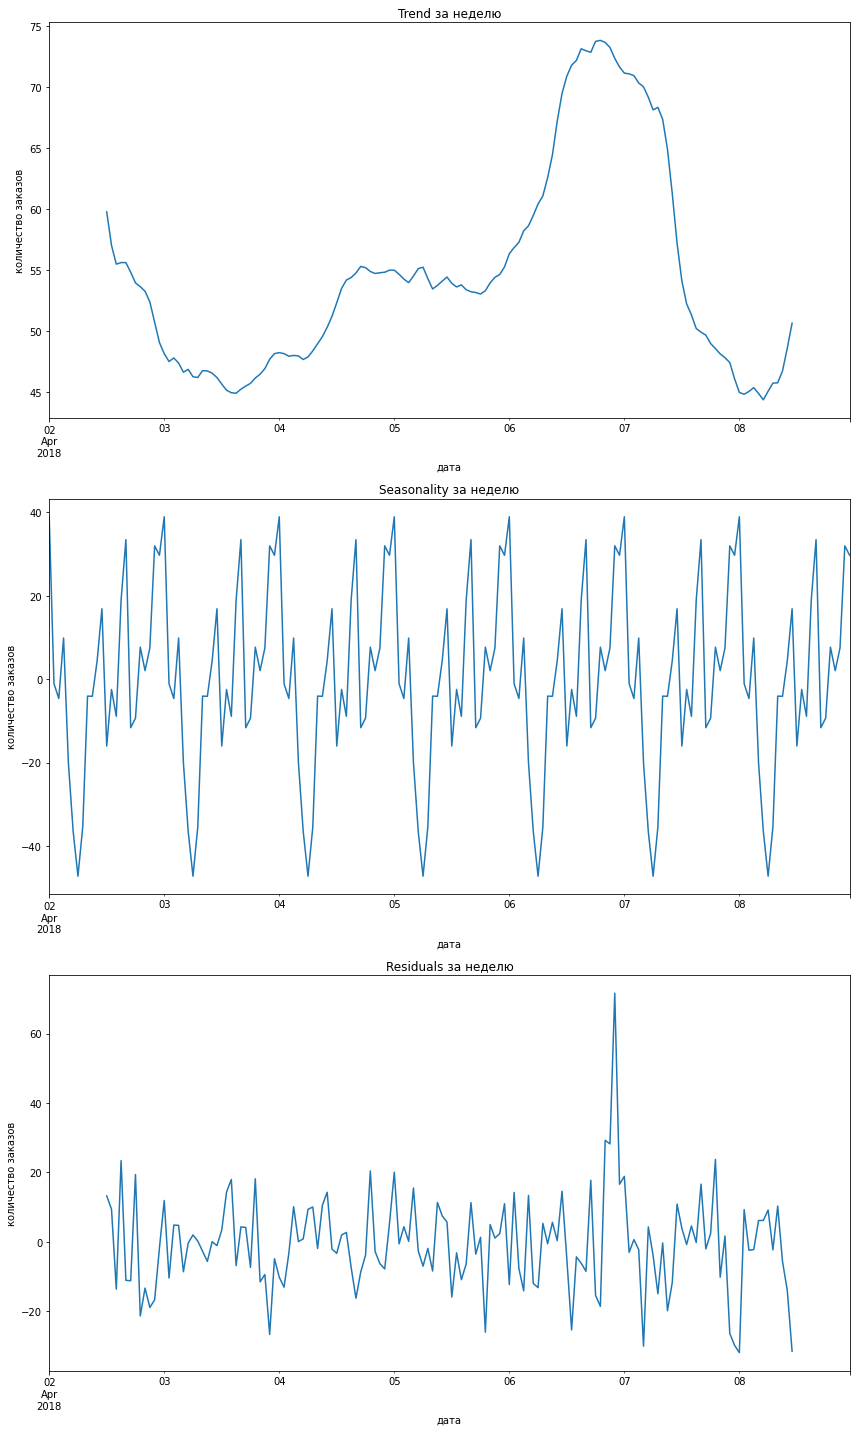

In [10]:
decomposed = seasonal_decompose(data['2018-04-02':'2018-04-08'])

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ylabel='количество заказов', xlabel='дата', ax=plt.gca())
plt.title('Trend за неделю')

plt.subplot(312)
decomposed.seasonal.plot(ylabel='количество заказов', xlabel='дата', ax=plt.gca())
plt.title('Seasonality за неделю')

plt.subplot(313)
decomposed.resid.plot(ylabel='количество заказов', xlabel='дата', ax=plt.gca())
plt.title('Residuals за неделю')
plt.tight_layout()

Явно виден недельный тренд, в пятницу и субботу больше всего заказов, все хотят погулять. Также видна суточная сезонность. Вечером самый большой спрос на услуги такси, а ночью он наоборот падает до минимума.

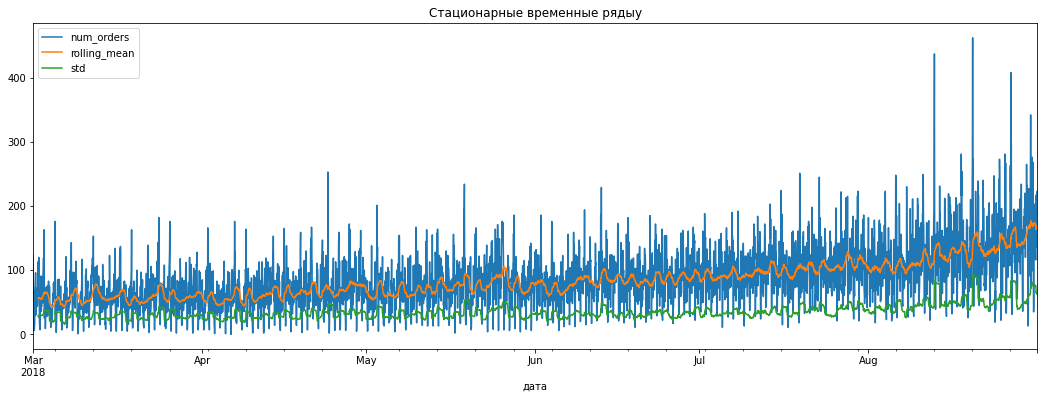

In [11]:
data_plot = data.copy()
data_plot['rolling_mean'] = data_plot.rolling(24).mean()
data_plot['std'] = data_plot['num_orders'].rolling(24).std()
data_plot.plot(title='Стационарные временные рядыy', label='количество заказов', xlabel='дата', figsize=(18, 6));

**Вывод:**
- Данные за 2018 год, начинаются с 1 марта и заканчиваются 31 августа
- В датасете 4416 строк, пропусков нет
- Виден недельный тренд, заказов в пятницу и субботу больше
- Есть суточная сезонность, вечером самый большой спрос
- Временной ряд не стационарный, ведь подвержен тренду, который меняется во времени

## Обучение

**Создадим признаки для обучения модели**

Признаки: Календарные, «Отстающие значения», Скользящее среднее 

Напишем функцию для создания признаков

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [13]:
make_features(data, 24, 48)

**Разделим данные на выборки**

In [14]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Функция для расчета метрики RMSE:

In [15]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5

RMSE_score = make_scorer(RMSE, greater_is_better=False)

**Модель "Линейная регрессия"**

In [16]:
%%time

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)

regression = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

regression.fit(features_train, target_train)

regression_cv_score = pd.Series(cross_val_score(regression,features_train,target_train,scoring=RMSE_score,cv=my_cv)).mean()*(-1)

print('Среднее качество модели линейной регрессии на кросс-валидации:', regression_cv_score)
print()

Среднее качество модели линейной регрессии на кросс-валидации: 28.236083190890884

CPU times: user 156 ms, sys: 370 ms, total: 525 ms
Wall time: 459 ms


**Модель "Случайный лес"**

In [17]:
%%time

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)

forest = RandomForestRegressor()

forest_parametrs = { 'n_estimators': range(5, 30, 5),
                     'max_depth': range(1, 15, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }


forest_grid = GridSearchCV(forest, forest_parametrs, scoring=RMSE_score, cv=my_cv)
forest_grid.fit(features_train, target_train)

CPU times: user 3min 54s, sys: 1.1 s, total: 3min 55s
Wall time: 3min 59s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f5b42195120>,
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 15, 2),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 8, 2),
                         'n_estimators': range(5, 30, 5)},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [18]:
%%time

forest_params = forest_grid.best_params_
forest_score = forest_grid.score(features_train, target_train) * (-1)
print(forest_params)
print('Среднее качество модели случайный лес на кросс-валидации:', forest_score)
print()


{'max_depth': 13, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 20}
Среднее качество модели случайный лес на кросс-валидации: 13.846311211680097

CPU times: user 13.7 ms, sys: 3.97 ms, total: 17.7 ms
Wall time: 20.3 ms


In [28]:
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
forest_cv = RandomForestRegressor(random_state=12345, max_depth=13, min_samples_leaf=1, min_samples_split=6, n_estimators=25)
scores_forest_cv = cross_val_score(forest_cv, features_train, target_train, scoring=RMSE_score, cv=my_cv).mean()*(-1)

In [29]:
print('Среднее качество модели случайный лес на кросс-валидации:', scores_forest_cv)
print()

Среднее качество модели случайный лес на кросс-валидации: 27.10573861184227



**Модель "CatBoost"**

In [21]:
%%time

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)

cb = cb.CatBoostRegressor()

cb_parametrs = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10]
               }


cb_grid = GridSearchCV(cb, cb_parametrs, scoring=RMSE_score, cv=my_cv)
cb_grid.fit(features_train, target_train, verbose=100)

0:	learn: 28.8931722	total: 48ms	remaining: 48s
100:	learn: 18.0590059	total: 198ms	remaining: 1.76s
200:	learn: 16.1457672	total: 362ms	remaining: 1.44s
300:	learn: 14.8007293	total: 547ms	remaining: 1.27s
400:	learn: 13.5275412	total: 701ms	remaining: 1.05s
500:	learn: 12.5542705	total: 851ms	remaining: 848ms
600:	learn: 11.6928906	total: 998ms	remaining: 663ms
700:	learn: 11.0091826	total: 1.14s	remaining: 487ms
800:	learn: 10.4177630	total: 1.3s	remaining: 323ms
900:	learn: 9.8465037	total: 1.46s	remaining: 160ms
999:	learn: 9.3216274	total: 1.61s	remaining: 0us
0:	learn: 31.6039032	total: 4.17ms	remaining: 4.17s
100:	learn: 20.2019251	total: 255ms	remaining: 2.27s
200:	learn: 18.4605830	total: 497ms	remaining: 1.98s
300:	learn: 17.4252678	total: 738ms	remaining: 1.71s
400:	learn: 16.5664453	total: 972ms	remaining: 1.45s
500:	learn: 15.8614830	total: 1.19s	remaining: 1.18s
600:	learn: 15.2873262	total: 1.4s	remaining: 930ms
700:	learn: 14.7235826	total: 1.58s	remaining: 674ms
800:	

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f5b41d127b0>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f5b421cbbe0>,
             param_grid={'depth': [4, 6, 10], 'learning_rate': [0.03, 0.1]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [22]:
cb_params = cb_grid.best_params_
cb_score = cb_grid.score(features_train, target_train) * (-1)
print(cb_params)

{'depth': 4, 'learning_rate': 0.03}


In [30]:
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
cv_cat = CatBoostRegressor(depth=4, learning_rate=0.03)
scores_cv_cat = cross_val_score(cv_cat, features_train, target_train, scoring=RMSE_score, cv=my_cv).mean()*(-1)

0:	learn: 28.8931722	total: 1.76ms	remaining: 1.76s
1:	learn: 28.5950076	total: 3.67ms	remaining: 1.83s
2:	learn: 28.2123837	total: 5.23ms	remaining: 1.74s
3:	learn: 27.8468744	total: 6.87ms	remaining: 1.71s
4:	learn: 27.5430778	total: 8.44ms	remaining: 1.68s
5:	learn: 27.2501581	total: 9.91ms	remaining: 1.64s
6:	learn: 26.9452079	total: 11.5ms	remaining: 1.63s
7:	learn: 26.6790841	total: 13.1ms	remaining: 1.62s
8:	learn: 26.4078093	total: 14.7ms	remaining: 1.62s
9:	learn: 26.1555983	total: 16.2ms	remaining: 1.6s
10:	learn: 25.8753489	total: 17.6ms	remaining: 1.58s
11:	learn: 25.6105811	total: 19ms	remaining: 1.57s
12:	learn: 25.3984384	total: 20.5ms	remaining: 1.56s
13:	learn: 25.1782511	total: 22.1ms	remaining: 1.56s
14:	learn: 24.9599760	total: 23.5ms	remaining: 1.54s
15:	learn: 24.7630346	total: 24.9ms	remaining: 1.53s
16:	learn: 24.5391819	total: 26.3ms	remaining: 1.52s
17:	learn: 24.3640390	total: 27.9ms	remaining: 1.52s
18:	learn: 24.1635049	total: 29.5ms	remaining: 1.52s
19:	le

In [31]:
print('Среднее качество модели случайный лес на кросс-валидации:', scores_cv_cat)

Среднее качество модели случайный лес на кросс-валидации: 25.708015694718384


**Сравним ROC AUC моделей на обучающихся выборках**

In [32]:
column=['Среднее качество модели на кросс-валидации']

comparison_tabl = pd.DataFrame(index=['Среднее качество модели на кросс-валидации'], columns=['LinearRegression','RandomForestRegressor','CatBoostRegressor'])
comparison_tabl['LinearRegression'] = regression_cv_score
comparison_tabl['RandomForestRegressor'] = scores_forest_cv
comparison_tabl['CatBoostRegressor'] = scores_cv_cat

comparison_tabl.T.style.highlight_min(color='green',subset=column).highlight_max(color='red',subset=column)

,Среднее качество модели на кросс-валидации
LinearRegression,28.236083
RandomForestRegressor,27.105739
CatBoostRegressor,25.708016


Лучше всего себя показывает модель "Случайный лес", применим ее к тестовой выборке

## Тестирование

In [26]:
print(forest_params)

{'max_depth': 13, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 20}


In [27]:
%%time

forest_model = RandomForestRegressor(random_state=12345,
                                     max_depth=13,
                                     min_samples_leaf = 4,
                                     min_samples_split = 6,
                                     n_estimators = 25)

forest_model.fit(features_train, target_train)
forest_model_predictions = forest_model.predict(features_test)

forest_RMSE = RMSE(target_test, forest_model_predictions)
print('RMSE модели Случайного леса:', forest_RMSE)

RMSE модели Случайного леса: 42.89751641330967
CPU times: user 887 ms, sys: 0 ns, total: 887 ms
Wall time: 886 ms


**RMSE модели Случайного леса на тестовой выборке составляет: 42.897, что соответствует условиям задачи**

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48